# 1. Teoría

El uso de boostlets o shearlets está basado en la proyección de una imagen en el espacio de Fourier y su descomposición con diferentes filtros que dividen el espacio de Fourier. Estos filtros los llamamos $\hat{\phi}_i$ en Fourier y ${\phi}_i$ en espacio físico. El espacio de Fourier estará por tanto dividido en "p" particiones cada una de ellas correspondiendo a un ${\phi}_i$.  
Todos estos ${\phi}_i$ conforman nuestro diccionario que llamaremos $Sk$.  
Los $\phi_i$ pueden solaparse en distintas zonas del espacio de Fourier.  
+ Lo ideal es que cuando nuestra imagen en Fourier la pasemos por cada uno de estos filtros, la suma de todas esas proyecciones nos de la imagen original de Fourier.






## Imagen objetivo y enmascarada en Fourier

Primero vemos cómo es la imagen original y la imagen enmascarada, que queremos procesar para recuperar la original.

+ Al ser una imagen 2D de numeros reales, al aplicar la transformada 2D de Fourier, se obtienen coeficientes con complejos conjugados con simetría puntual desde el centro (0,0)
  

In [14]:
%load_ext autoreload
%autoreload 2
import os
import numpy as np
import matplotlib.pyplot as plt

from boostlets_mod import Boostlet_syst
from mod_plotting_utilities import plot_array_images, plot_ls_images
from mod_RIRIS_func import load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR
from mod_RIRIS_func import computePareto, ista, iffst, linear_interpolation_fft, perforMetrics


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


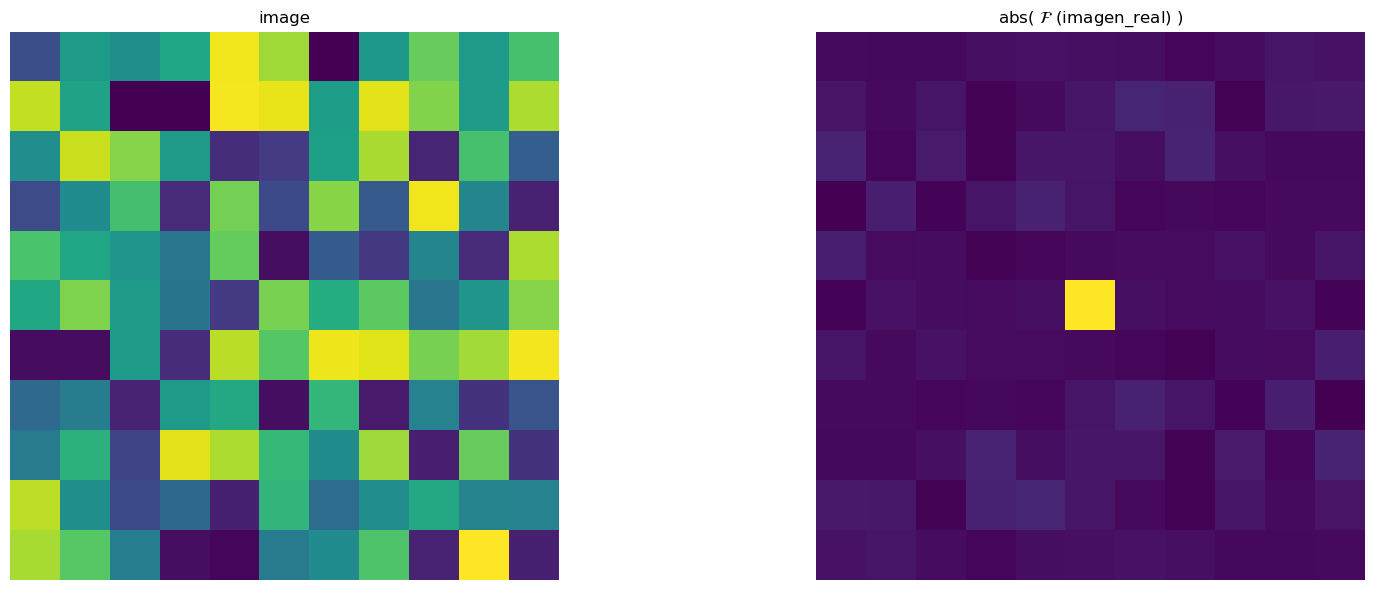

In [18]:
A = np.random.rand(11, 11)
FA = np.fft.fftshift(np.fft.fft2(A))

images = [A, np.abs(FA)]
titles = ["image",  r"abs( $\mathcal{F}$ (imagen_real) )"]
plot_ls_images(images, titles)



In [21]:

ix = 1
iy = 1
c_rows, c_cols = FA.shape
c_rows //= 2 
c_cols //= 2


print("Complex conjugates for points with point symmetry:")
print("----------------------------------------")
print(f"  (+kx, +ky) = {FA[c_rows+iy, c_cols+ix]} ")
print(f"  (-kx, -ky) = {FA[c_rows-iy, c_cols-ix]} ")
print("----------------------------------------")
print(f"  (+kx, -ky) = {FA[c_rows-iy, c_cols+ix]} ")
print(f"  (-kx, +ky) = {FA[c_rows+iy, c_cols-ix]} ")






Values at:
----------------------------------------
  (+kx, +ky) = (1.111164294234019-0.8307496893020061j) 
  (-kx, -ky) = (1.111164294234019+0.8307496893020061j) 
----------------------------------------
  (+kx, -ky) = (1.249009170516067+1.770341720936695j) 
  (-kx, +ky) = (1.249009170516067-1.770341720936695j) 


In [22]:
import os
from mod_RIRIS_func import load_sk, load_DB_ZEA, rand_downsamp_RIR, ImageOps, jitter_downsamp_RIR

# Imagen tamaño:
M0, N0 = 100, 100
ratio_mics = 0.5
# ---------- LOAD image ---------------------------
room= 'Balder'
folder = "./dependencies/measurementData"
file = room+"RIR.mat"
file_path = os.path.join(folder, file)

full_image, x, t = load_DB_ZEA(file_path)
x = x.flatten()
dx = x[1]-x[0]

t = t.flatten()
dt = t[1]-t[0]

Tstart = 0
Im1 = full_image[Tstart:Tstart+M0, :N0]
Tstart = 1000
Im2 = full_image[Tstart:Tstart+M0, :N0]

mask0, _ = jitter_downsamp_RIR(Im1.shape, ratio_t=1, ratio_x=ratio_mics)

images = [Im1, Im1*mask0, Im2, Im2*mask0,]
titles = ["Im 1", "Masked Im 1","Im 2","Masked Im 2"]
plot_ls_images(images, titles)

In [6]:
Tstart = 300
Im1 = full_image[Tstart:Tstart+M0, :N0]
Tstart = 1000
Im2 = full_image[Tstart:Tstart+M0, :N0]
mask0, _ = jitter_downsamp_RIR(Im1.shape, ratio_t=1, ratio_x=ratio_mics)

F1  = np.fft.fftshift(np.fft.fft2(Im1))
F2  = np.fft.fftshift(np.fft.fft2(Im2))
FM1 = np.fft.fftshift(np.fft.fft2(Im1*mask0))
FM2 = np.fft.fftshift(np.fft.fft2(Im2*mask0))

images = [np.abs(F1), np.abs(FM1), np.abs(F2), np.abs(FM2),]
titles = ["F(Im1)", "F(Masked Im1)","F(Im2)","F(Masked Im2)"]
plot_ls_images(images, titles)

In [21]:


kx = np.fft.fftfreq(N0, dx) # [1/m]
kx = np.fft.fftshift( kx ) # centered freqs

kt = np.fft.fftfreq(M0, dt) # [1/s]
kt = np.fft.fftshift( kt ) # centered freqs




In [48]:
# m_points = M0
b = 1
m_points = 8
omega = np.fft.fftshift( np.fft.fftfreq(m_points) )*2*b 
print(omega)

[-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75]


In [66]:
M, N = 100, 100
cs = 340

om = np.fft.fftshift( np.fft.fftfreq(n=M, d=dt) )
kx = np.fft.fftshift( np.fft.fftfreq(n=N, d=dx) )
k = cs * kx


print(dx) 
print(1/dt) 
print(cs) 



0.03
11250.0
340


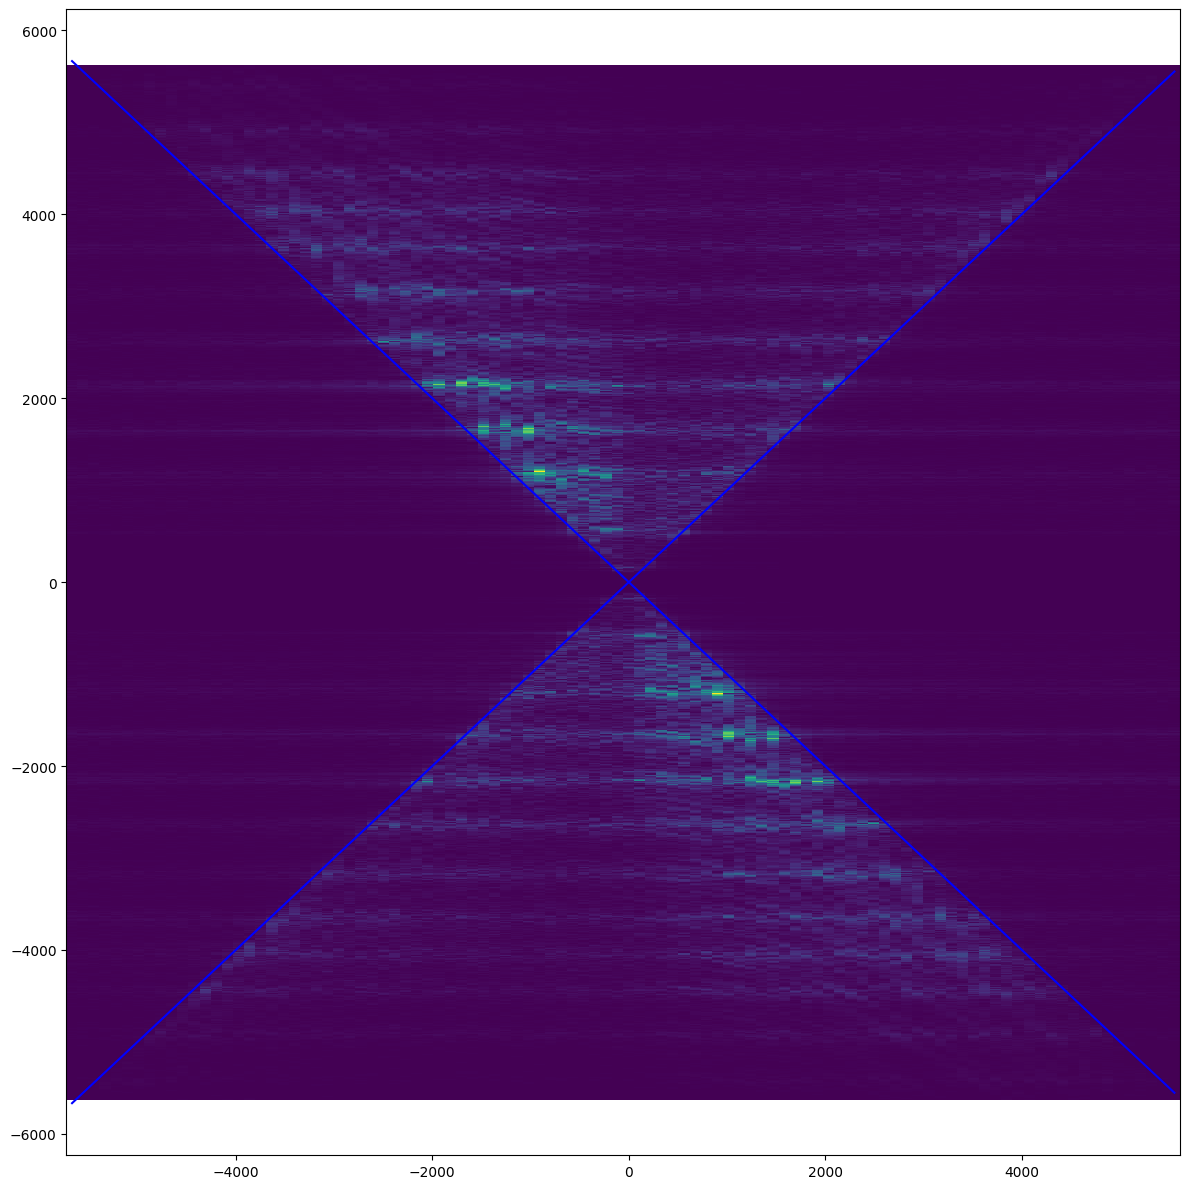

In [63]:
Tstart = 0
M1, M2 = 1000, 3000
Im1 = full_image[Tstart:Tstart+M1, :N0]
Tstart = 1
Im2 = full_image[Tstart:Tstart+M2, :N0]

M, N = M1, N0
cs = 340
om = np.fft.fftshift( np.fft.fftfreq(n=M, d=dt) ) # [1/m] , centered freqs
kx = np.fft.fftshift( np.fft.fftfreq(n=N, d=dx) ) # [1/s] , centered freqs
k = cs * kx # Use for boostlets with symmetrical cones

F1  = np.fft.fftshift(np.fft.fft2(Im1))
F2  = np.fft.fftshift(np.fft.fft2(Im2))

images = [np.abs(F1),  np.abs(F2), ]
titles = ["F(Im1)" ,"F(Im2)",]

fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.pcolor(k, om, images[0])
ax.plot(k, k, 'b')
ax.plot(k, -k, 'b')
plt.tight_layout()
plt.show()


## Dicc boostlet (no-Parseval)

El metodo ISTA es un metodo recursivo, por lo que puede ser interesante ver cómo afecta la recursividad en las proyecciones con el diccionario.  
La funcion alphas = ffst(image, Sk) obtiene los coeficientes en físico (alphas), resultado de proyectar la imagen (image) en el diccionario (Sk) de funciones ($\phi_i$).  
La funcion rec_image = iffst(alphas, Sk), obtiene la imagen (rec_image) recobrada de los coeficientes (alphas) y el diccionario Sk.  
+ En esta proyeccion image -> alphas -> rec_image, si el diccionario no es de Parseval, la reconstrucción no sera perfecta. 
    - Al usar un metodo iterativo que proyectara multiples veces la imagen, podemos diverger debido a que el dicc no es de tipo Parseval.



- Cargar imagen e imagen con pad y sus respectivos diccionarios Sk

In [68]:
from mod_RIRIS_func import load_sk, ffst, iffst, ImageOps

Tstart = 0
image = full_image[Tstart:Tstart+100, :N0]
extr_size = (128,128)
extrap_mode = 'pad'
imOps = ImageOps(image.shape, mask=np.ones(image.shape[1]), extrap_shape=extr_size, mode=extrap_mode) 
image_ext = imOps.expand_image(image)

S, n_thetas = 1, 5

build_dict = dict(Sk_type = 'boostlet', N = image.shape[0], S = S, n_thetas = n_thetas)
Sk = load_sk(folder='./', file='dummy', build_dict=build_dict)

build_dict = dict(Sk_type = 'boostlet', N = image_ext.shape[0], S = S, n_thetas = n_thetas)
Sk_ext = load_sk(folder='./', file='dummy', build_dict=build_dict)



Generating boostlet dictionary. N=100, S=1, n_thetas=5
Generating boostlet dictionary. N=128, S=1, n_thetas=5


+ Funcion para proyectar y recobrar la imagen

In [69]:
def proyection(image, Sk):
    alf = ffst(image, Sk)
    rec_im = iffst(alf, Sk)
    return rec_im


- Resultados recursion para imagen sin pad

 iter 0/50.  Residue: 1.6181228424117247
 iter 1/50.  Residue: 4.57268966599968
 iter 2/50.  Residue: 10.009640907897548
 iter 3/50.  Residue: 20.065379736701598
 iter 4/50.  Residue: 38.72819235761791
 iter 5/50.  Residue: 73.4540010999565
 iter 6/50.  Residue: 138.20028407137877
 iter 7/50.  Residue: 259.128158912045
 iter 8/50.  Residue: 485.3280449130472
 iter 9/50.  Residue: 909.0100094946256
 iter 10/50.  Residue: 1703.5369297489965
 iter 11/50.  Residue: 3195.1133757739262
 iter 12/50.  Residue: 5997.988590777134
 iter 13/50.  Residue: 11269.575534976637
 iter 14/50.  Residue: 21192.067405333797
 iter 15/50.  Residue: 39882.0237258836
 iter 16/50.  Residue: 75108.8892178497
 iter 17/50.  Residue: 141543.0145321253
 iter 18/50.  Residue: 266896.4540274285
 iter 19/50.  Residue: 503536.415194668
 iter 20/50.  Residue: 950454.6611697937
 iter 21/50.  Residue: 1794838.1832583637
 iter 22/50.  Residue: 3390748.3773396243
 iter 23/50.  Residue: 6408067.267059439
 iter 24/50.  Residue:

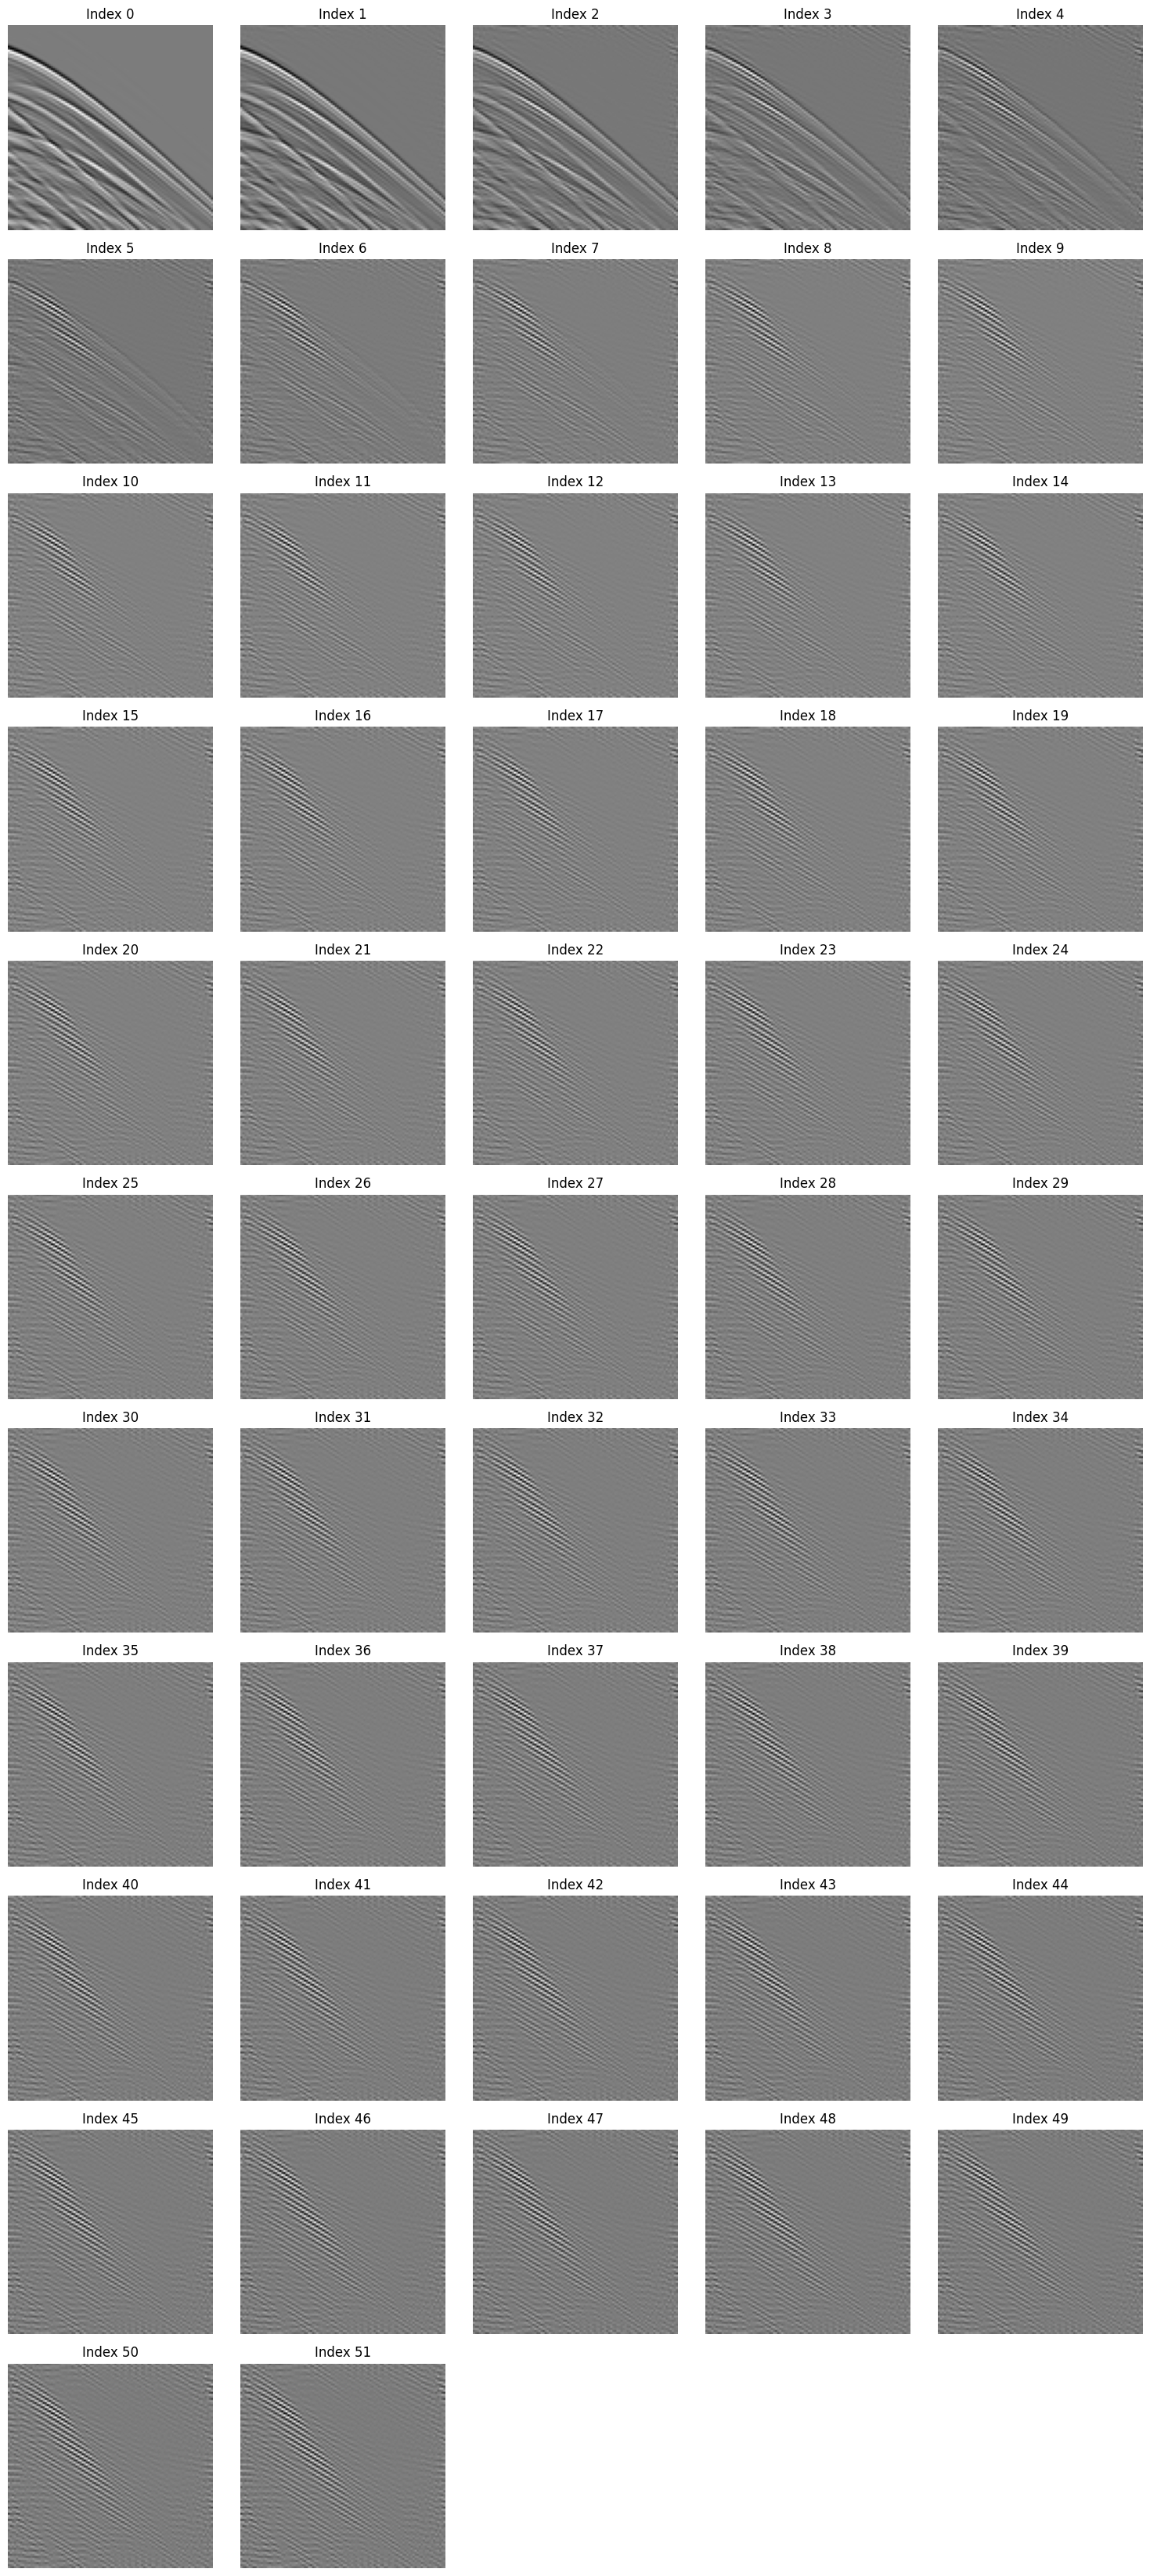

In [70]:
max_iter = 50
rec_im = proyection(image, Sk)

images = [image, rec_im]
for i in range(max_iter):
    dif_image = image-rec_im
    resid = np.linalg.norm(dif_image, 2)
    print(f" iter {i}/{max_iter}.  Residue: {resid}")

    rec_im = proyection(rec_im, Sk)
    images.append(rec_im)

dif_image = image-rec_im
resid = np.linalg.norm(dif_image, 2)
print(f" iter {max_iter}/{max_iter}.  Residue: {resid}")

# images = np.fft.fftshift( np.fft.fft2(images, axes=(0,1)), axes=(0,1) )
plot_array_images(array=images, num_cols=5)


In [71]:
ims = [im-images[0] for im in images]
ims_arr = np.stack(ims, axis=2)

d_fft_ims = np.abs( np.fft.fftshift( np.fft.fft2(ims_arr, axes=(0,1)), axes=(0,1) ) )



In [80]:
nx = ims_arr.shape[1]
ny = ims_arr.shape[0]

xax = np.arange(nx) - (nx//2)
yax = np.arange(ny) - (ny//2)

id = 1
fig, ax = plt.subplots(1,1)
c1 = ax.pcolor(xax, yax, d_fft_ims[:,:,id])
ax.grid('on')

# ax[0].pcolor(xax, yax, d_fft_ims[:,:,id])
# # ax.pcolor(ims_arr[:,:,id])
# ax[0].grid('on')
# ax[1].pcolor(xax, yax, np.abs(Sk[:,:,id]))
# ax[1].grid('on')

plt.colorbar(c1)
plt.show()


[-50 -49 -48 -47 -46 -45 -44 -43 -42 -41 -40 -39 -38 -37 -36 -35 -34 -33
 -32 -31 -30 -29 -28 -27 -26 -25 -24 -23 -22 -21 -20 -19 -18 -17 -16 -15
 -14 -13 -12 -11 -10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3
   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21
  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49]


In [ ]:
nx = ims_arr.shape[1]
ny = ims_arr.shape[0]

xax = np.arange(nx) - (nx//2)
yax = np.arange(ny) - (ny//2)

id = 6
fig, ax = plt.subplots(1,1)
c1 = ax.pcolor(xax, yax, d_fft_ims[:,:,id])
ax.grid('on')

# ax[0].pcolor(xax, yax, d_fft_ims[:,:,id])
# # ax.pcolor(ims_arr[:,:,id])
# ax[0].grid('on')
# ax[1].pcolor(xax, yax, np.abs(Sk[:,:,id]))
# ax[1].grid('on')

plt.colorbar(c1)
plt.show()

print(xax)

- resultados recursion para imagen con pad

 iter 0/50.  Residue: 1.6334442104192388
 iter 1/50.  Residue: 4.626182152448606
 iter 2/50.  Residue: 10.149125274044911
 iter 3/50.  Residue: 20.390385418208012
 iter 4/50.  Residue: 39.444528413807205
 iter 5/50.  Residue: 74.98398708076542
 iter 6/50.  Residue: 141.40347156824495
 iter 7/50.  Residue: 265.74020252013145
 iter 8/50.  Residue: 498.8284206230705
 iter 9/50.  Residue: 936.3297754433554
 iter 10/50.  Residue: 1758.4071249934566
 iter 11/50.  Residue: 3304.6097688613927
 iter 12/50.  Residue: 6215.290877794895
 iter 13/50.  Residue: 11698.788041475853
 iter 14/50.  Residue: 22036.415630084357
 iter 15/50.  Residue: 41537.298417771875
 iter 16/50.  Residue: 78344.38114225437
 iter 17/50.  Residue: 147851.46667311122
 iter 18/50.  Residue: 279170.2679793604
 iter 19/50.  Residue: 527373.1879027539
 iter 20/50.  Residue: 996675.9287406808
 iter 21/50.  Residue: 1884345.6805855378
 iter 22/50.  Residue: 3563881.8506468385
 iter 23/50.  Residue: 6742627.4978997335
 iter 24/50

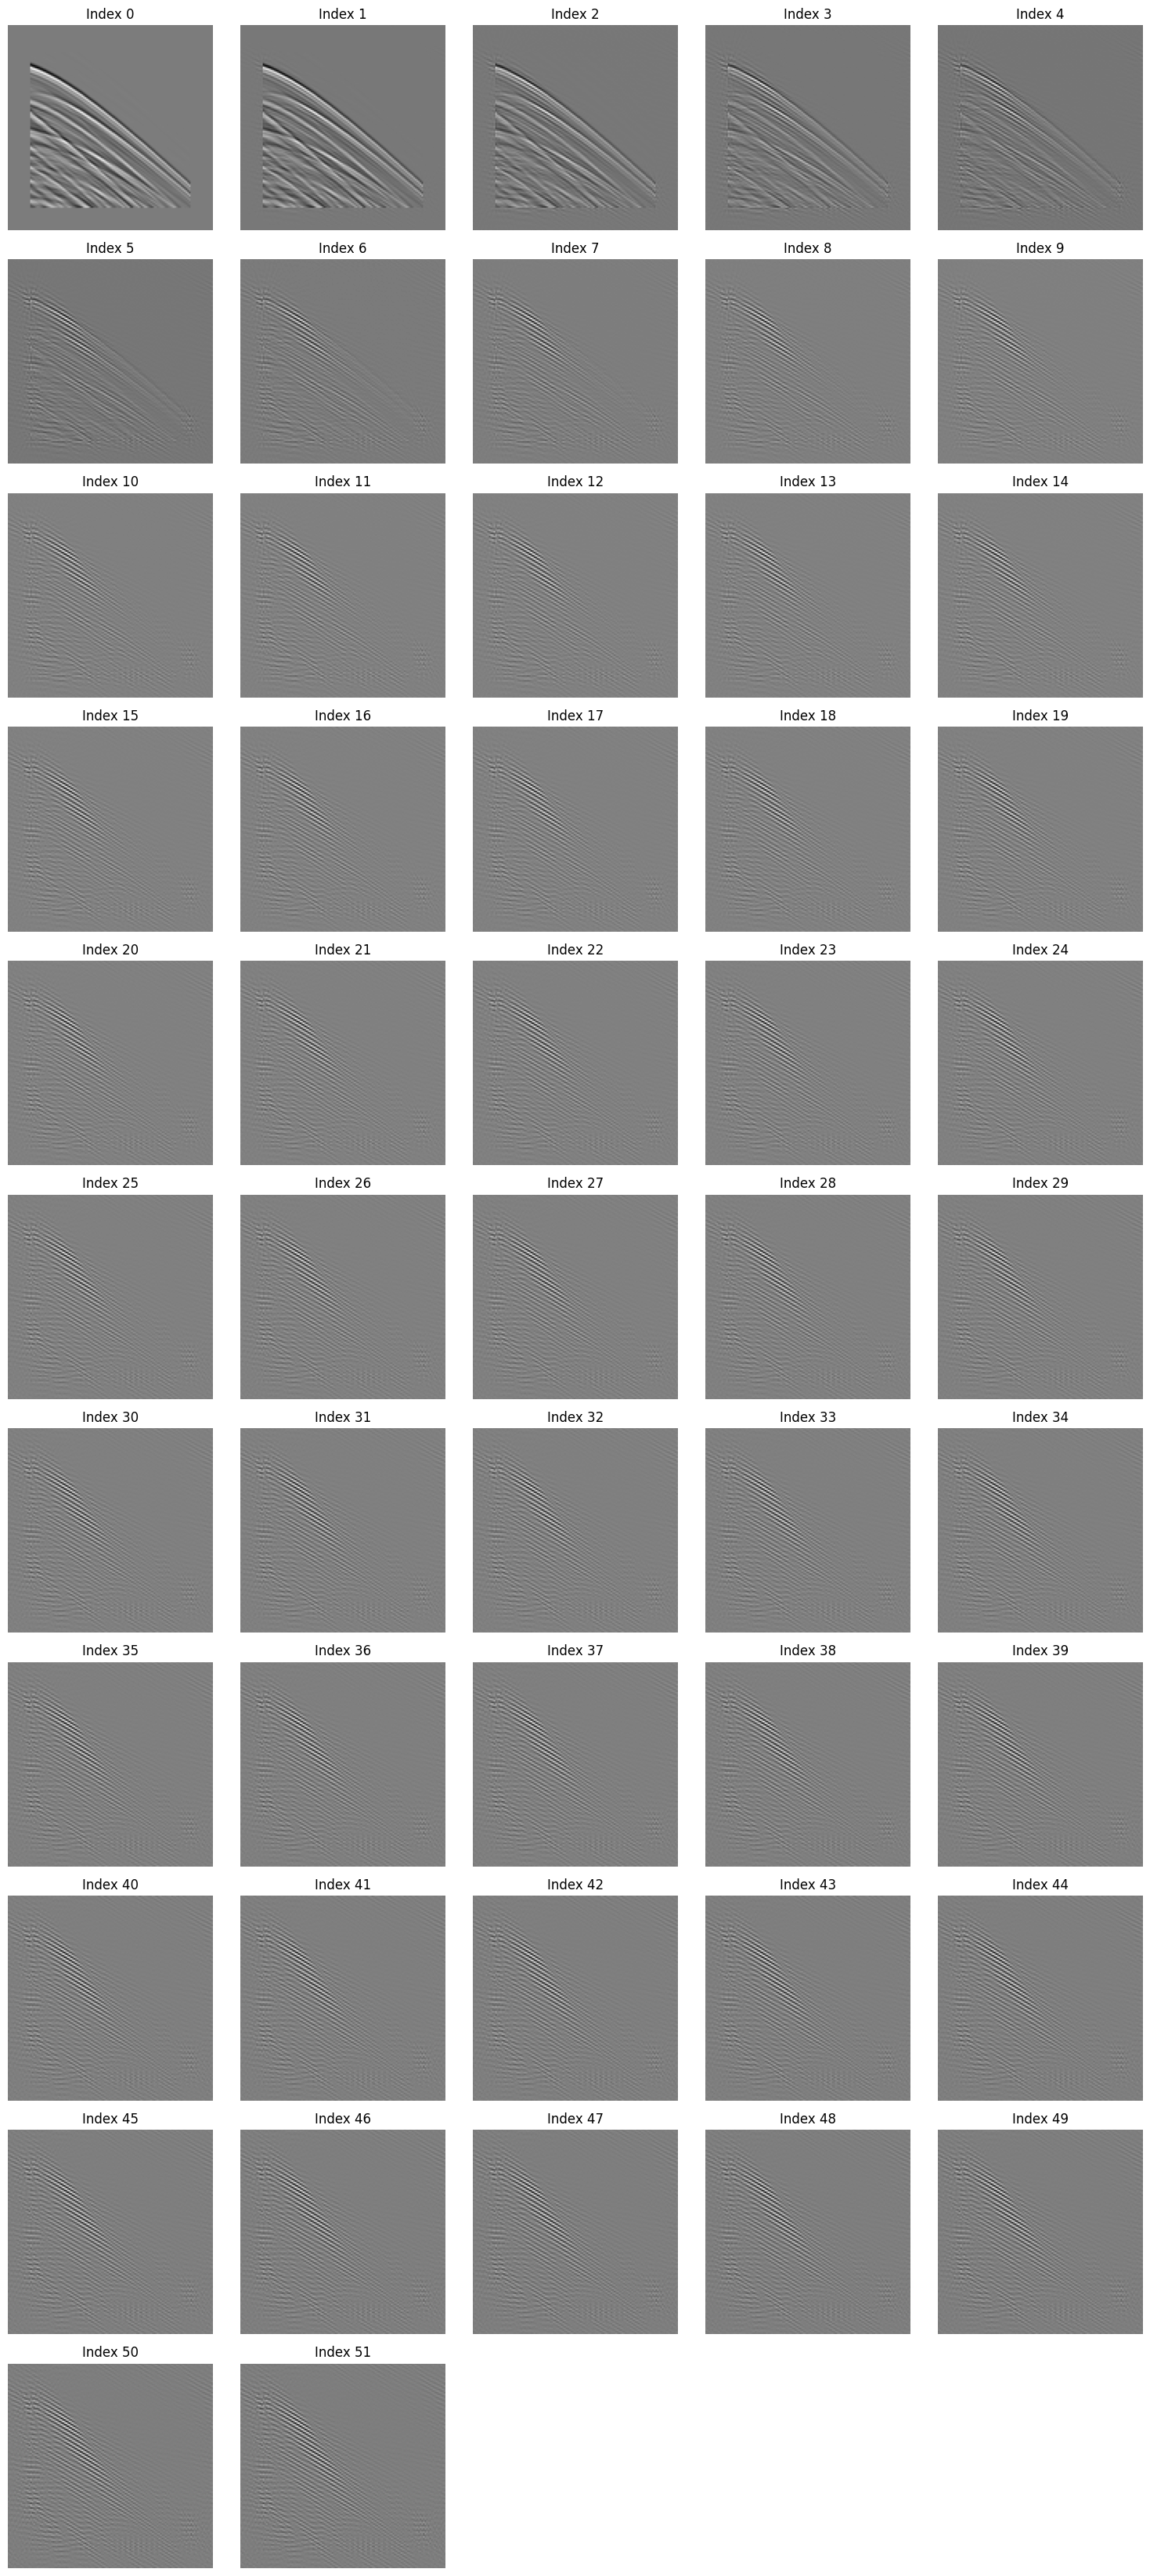

In [30]:
max_iter = 50
rec_im = proyection(image_ext, Sk_ext)

images = [image_ext, rec_im]
for i in range(max_iter):
    dif_image = image_ext-rec_im
    resid = np.linalg.norm(dif_image, 2)
    print(f" iter {i}/{max_iter}.  Residue: {resid}")

    rec_im = proyection(rec_im, Sk_ext)
    images.append(rec_im)

dif_image = image_ext-rec_im
resid = np.linalg.norm(dif_image, 2)
print(f" iter {max_iter}/{max_iter}.  Residue: {resid}")

plot_array_images(array=images, num_cols=5)